#Задача uplift-моделирования

__1. скачать набор данных маркетинговых кампаний отсюда__ https://www.kaggle.com/davinwijaya/customer-retention


In [1]:
!pip install scikit-uplift catboost

In [2]:
!unzip data.csv.zip

Archive:  data.csv.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


__2. поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.__


In [5]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [6]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [7]:
treatment_to_bin = {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}
df['treatment'] = df['treatment'].replace(treatment_to_bin)
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [8]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


__3. сделать разбиение набора данных нa тренировочную и тестовую выборки__


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_new = df.drop(['treatment', 'target'], axis=1)
df_new.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,Surburban,0,Phone
1,6,329.08,1,1,Rural,1,Web
2,7,180.65,0,1,Surburban,1,Web


In [11]:
df_train = df[['treatment', 'target']]
df_train.head(3)

,treatment,target
0,1,0
1,0,0
2,1,0


In [12]:
df_test = df_train.drop(['treatment', 'target'], axis=1)
df_test.head(3)

""
0
1
2


In [13]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(indices_train, test_size=0.3, random_state=42)

__4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)__


In [14]:
df_features = df_new.copy()
# Обзор количественных признаков
df_features.describe()


,recency,history,used_discount,used_bogo,is_referral
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250
std,3.507592,256.158608,0.497393,0.497526,0.499999
min,1.000000,29.990000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000


In [15]:
 # Обзор номинативных признаков
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

zip_code

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64
****************************************************************************************************

channel

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64
****************************************************************************************************



In [16]:
# Дамми-переменные из строковых признаков 
df_features = pd.concat([df_features, pd.get_dummies(df_features[['zip_code', 'channel']])], axis=1)
df_features.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,Surburban,0,Phone,0,1,0,0,1,0
1,6,329.08,1,1,Rural,1,Web,1,0,0,0,0,1
2,7,180.65,0,1,Surburban,1,Web,0,1,0,0,0,1
3,9,675.83,1,0,Rural,1,Web,1,0,0,0,0,1
4,2,45.34,1,0,Urban,0,Web,0,0,1,0,0,1


In [17]:
# Средний "чек" по признаку zip_code
df_cat = df_features.groupby('zip_code', as_index=False).mean()[['zip_code', 'history']]
df_cat = pd.DataFrame(df_cat)

df_cat

,zip_code,history
0,Rural,242.853935
1,Surburban,240.488905
2,Urban,243.589924


In [18]:
df_cat.rename(columns={'history': 'median_zip_purchases'}, inplace=True)

df_cat.sort_values(by='median_zip_purchases')

,zip_code,median_zip_purchases
1,Surburban,240.488905
0,Rural,242.853935
2,Urban,243.589924


In [19]:
df_features = df_features.merge(df_cat, on=['zip_code'])

df_features.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,median_zip_purchases
0,10,142.44,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905
1,7,180.65,0,1,Surburban,1,Web,0,1,0,0,0,1,240.488905
2,6,134.83,0,1,Surburban,0,Phone,0,1,0,0,1,0,240.488905


In [20]:
# Средний "чек" по признаку channel
df_cat = df_features.groupby('channel', as_index=False).mean()[['channel', 'history']]
df_cat = pd.DataFrame(df_cat)

df_cat

,channel,history
0,Multichannel,520.970370
1,Phone,202.807184
2,Web,204.375017


In [21]:
df_cat.rename(columns={'history': 'median_channel_purchases'}, inplace=True)

df_cat.sort_values(by='median_channel_purchases')

,channel,median_channel_purchases
1,Phone,202.807184
2,Web,204.375017
0,Multichannel,520.970370


In [22]:
df_features = df_features.merge(df_cat, on=['channel'])

df_features.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,median_zip_purchases,median_channel_purchases
0,10,142.44,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184
1,6,134.83,0,1,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184
2,9,280.20,1,0,Surburban,1,Phone,0,1,0,0,1,0,240.488905,202.807184


In [23]:
# Средний "чек" по признаку recency
df_cat = df_features.groupby('recency', as_index=False).mean()[['recency', 'history']]
df_cat = pd.DataFrame(df_cat)

df_cat

,recency,history
0,1,359.844955
1,2,310.990777
2,3,274.462007
3,4,251.310701
4,5,233.153233
5,6,218.387238
6,7,207.557580
7,8,194.924066
8,9,185.874574
9,10,172.104997


In [24]:
df_cat.rename(columns={'history': 'median_recency_purchases'}, inplace=True)

df_cat.sort_values(by='median_recency_purchases')

,recency,median_recency_purchases
11,12,153.984108
10,11,168.015759
9,10,172.104997
8,9,185.874574
7,8,194.924066
6,7,207.557580
5,6,218.387238
4,5,233.153233
3,4,251.310701
2,3,274.462007


In [25]:
df_features = df_features.merge(df_cat, on=['recency'])

df_features.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,median_zip_purchases,median_channel_purchases,median_recency_purchases
0,10,142.44,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997
1,10,29.99,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997
2,10,77.37,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997


In [26]:
# Категории по "чеку":
# 1: до 50$
# 2: до 100$
# 3: до 500$
# 4: до 1000$
# 5: свыше 1000$
df_features['history'].describe()

count    64000.000000
mean       242.085656
std        256.158608
min         29.990000
25%         64.660000
50%        158.110000
75%        325.657500
max       3345.930000
Name: history, dtype: float64

In [27]:
def history_to_cat(X):

    X['history_cat'] = 0

    X.loc[X['history'] <= 50, 'history_cat'] = 1  
    X.loc[(X['history'] > 50) & (X['history'] <= 100), 'history_cat'] = 2
    X.loc[(X['history'] > 100) & (X['history'] <= 500), 'history_cat'] = 3
    X.loc[(X['history'] > 500) & (X['history'] <= 1000), 'history_cat'] = 4
    X.loc[X['history'] > 1000, 'history_cat'] = 5

    return X

In [28]:
df_features = history_to_cat(df_features)
df_features.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,median_zip_purchases,median_channel_purchases,median_recency_purchases,history_cat
0,10,142.44,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997,3
1,10,29.99,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997,1
2,10,77.37,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997,2
3,10,153.58,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997,3
4,10,47.47,0,1,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997,1


In [29]:
# 2 Категории по "чеку":
# 0: до 1000$
# 1: свыше 1000$
def history_to_binary_cat(X):

    X['history_binary_cat'] = 0
    X.loc[X['history'] >= 1000, 'history_binary_cat'] = 1  

    return X

In [30]:
df_features = history_to_binary_cat(df_features)
df_features.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,median_zip_purchases,median_channel_purchases,median_recency_purchases,history_cat,history_binary_cat
0,10,142.44,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997,3,0
1,10,29.99,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997,1,0
2,10,77.37,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997,2,0
3,10,153.58,1,0,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997,3,0
4,10,47.47,0,1,Surburban,0,Phone,0,1,0,0,1,0,240.488905,202.807184,172.104997,1,0


In [31]:
# Отбор признаков
df_features.columns.to_list()

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'zip_code',
 'is_referral',
 'channel',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web',
 'median_zip_purchases',
 'median_channel_purchases',
 'median_recency_purchases',
 'history_cat',
 'history_binary_cat']

In [32]:
df_features = df_features.drop(['zip_code', 'channel'], axis=1)
df_features.fillna(0, inplace=True)
df_features.head(3)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,median_zip_purchases,median_channel_purchases,median_recency_purchases,history_cat,history_binary_cat
0,10,142.44,1,0,0,0,1,0,0,1,0,240.488905,202.807184,172.104997,3,0
1,10,29.99,1,0,0,0,1,0,0,1,0,240.488905,202.807184,172.104997,1,0
2,10,77.37,1,0,0,0,1,0,0,1,0,240.488905,202.807184,172.104997,2,0


In [33]:
# Заведем переменные
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']


X_test = df_features.loc[indices_test, :]

#cat_features = [['zip_code', 'channel']]

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [34]:
X_train.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,median_zip_purchases,median_channel_purchases,median_recency_purchases,history_cat,history_binary_cat
9656,6,378.17,1,0,0,0,1,0,0,0,1,240.488905,204.375017,218.387238,3,0
63037,4,82.16,1,0,1,0,0,1,0,0,1,243.589924,204.375017,251.310701,2,0
31405,2,235.49,1,0,1,0,0,1,0,1,0,243.589924,202.807184,310.990777,3,0
58088,1,732.96,0,1,1,1,0,0,1,0,0,242.853935,520.970370,359.844955,4,0
44344,7,805.72,1,1,1,0,1,0,0,0,1,240.488905,204.375017,207.557580,4,0


In [35]:
# Описание воздействия
treat_train.head()

9656     0
63037    1
31405    1
58088    0
44344    1
Name: treatment, dtype: int64

In [36]:
# Описание целевого действия
y_train.head()

9656     0
63037    0
31405    1
58088    0
44344    0
Name: target, dtype: int64

__5. провести uplift-моделирование 3 способами:__

   1. одна модель с признаком коммуникации (S-learner)
   2. модель с трансформацией таргета
   3. вариант с двумя независимыми моделями


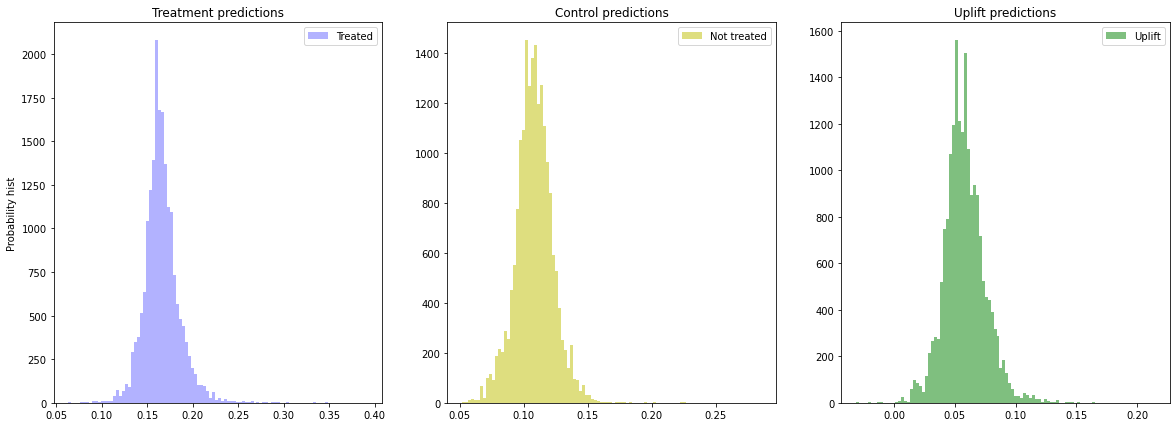

In [37]:
# Одна модель
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True)
)

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score)
models_results['uplift@20%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [38]:
# Посмотрим на топ-признаки
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,26.919265
1,history,14.090874
2,recency,9.944977
3,median_channel_purchases,8.385360
4,median_recency_purchases,8.310945
5,median_zip_purchases,7.979303
6,channel_Web,4.202797
7,is_referral,3.960447
8,used_discount,3.677976
9,used_bogo,3.493533


In [39]:
sm_score

0.0776464873260397

In [40]:
from sklift.viz import plot_uplift_by_percentile
from sklift.viz import plot_uplift_curve

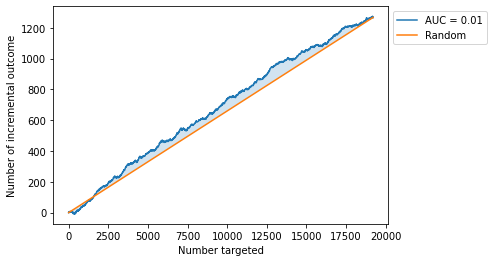

In [41]:
# with ideal curve
# perfect=True
plot_uplift_curve(
    y_val, uplift_sm, treat_val, 
    # perfect=True
    perfect=False
);

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


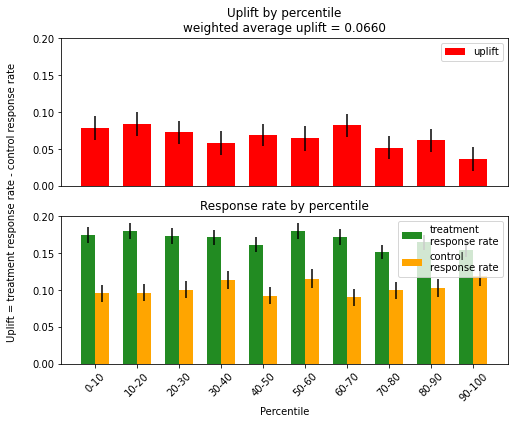

In [42]:
# график uplift by percentile
plot_uplift_by_percentile(y_val, uplift_sm, treat_val, 
                          strategy='overall', kind='bar'); # line

In [52]:
# Модель с трансформацией таргета
from sklift.models import ClassTransformation


ct = ClassTransformation(
    CatBoostClassifier(iterations=20, random_state=42, silent=True)
)
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score)
models_results['uplift@20%'].append(ct_score)

In [44]:
ct_score

0.0714122668209009

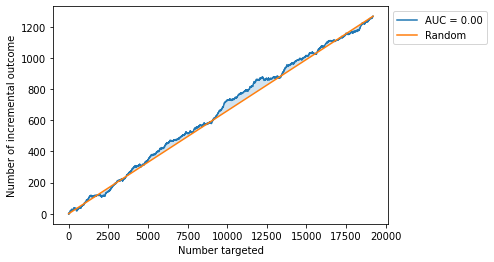

In [45]:
# with ideal curve
# perfect=True
plot_uplift_curve(
    y_val, uplift_ct, treat_val, 
    # perfect=True
    perfect=False
);

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


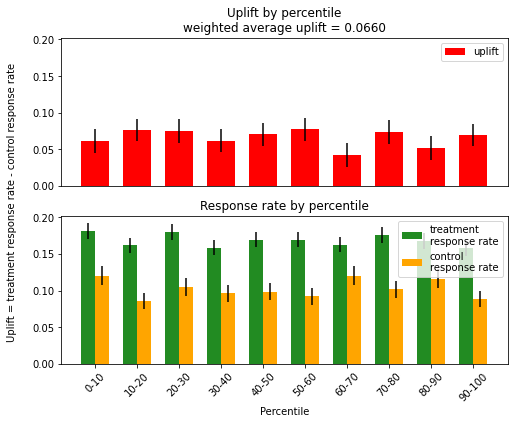

In [46]:
# график uplift by percentile
plot_uplift_by_percentile(y_val, uplift_ct, treat_val, 
                          strategy='overall', kind='bar'); # line

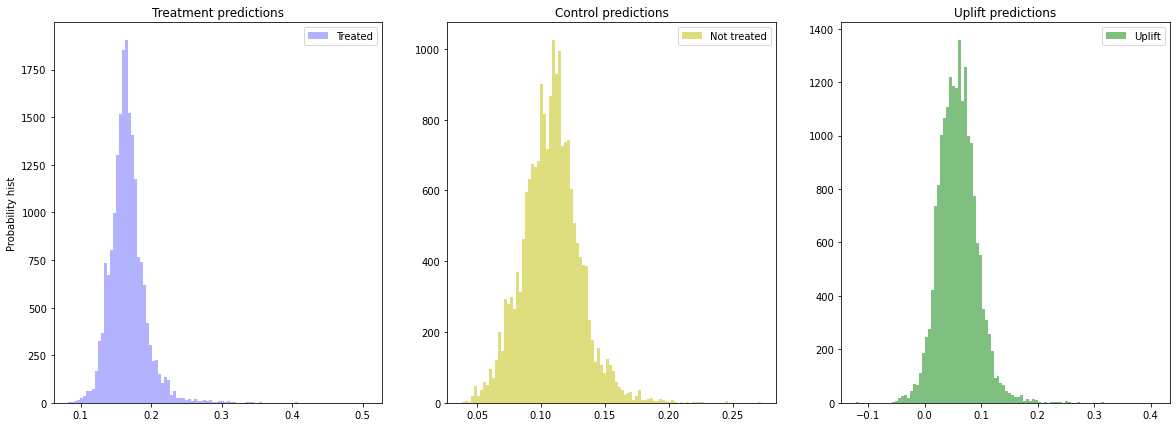

In [47]:
# Две независимые модели
from sklift.models import TwoModels


tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True),
    CatBoostClassifier(iterations=20, random_state=42, silent=True),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score)
models_results['uplift@20%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [48]:
tm_score

0.07689724902006019

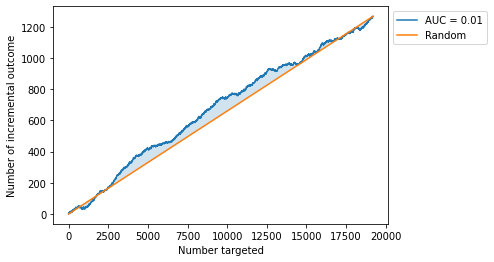

In [53]:
# with ideal curve
# perfect=True
plot_uplift_curve(
    y_val, uplift_tm, treat_val, 
    # perfect=True
    perfect=False
);

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


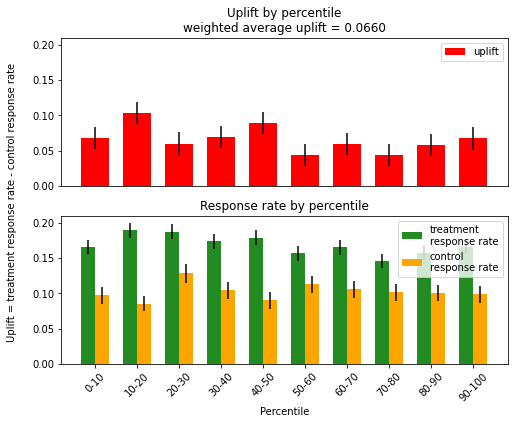

In [54]:
# график uplift by percentile
plot_uplift_by_percentile(y_val, uplift_tm, treat_val, 
                          strategy='overall', kind='bar'); # line

__6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей__

In [49]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.077646,0.077646
2,TwoModels,0.076897,0.076897
1,ClassTransformation,0.071412,0.071412
